# Data Engineer (Python, SQL)Test Task

## Task Steps:
#### 1. Collect information about Pokemons.
#### 2. Find the Pokemon which is the most effective companion through all generations (rank the pokemons from best to worst).
#### 3. Export data to Google Spreadsheets for creating a dashboard in Google Looker Studio so the user could filter data and see which type of Pokemon is the most suited for him.

### Import libraries and utility functions

In [12]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import gspread
from google.oauth2.service_account import Credentials

### Get Pokemon data

In [13]:
url = "https://gist.githubusercontent.com/simsketch/1a029a8d7fca1e4c142cbfd043a68f19/raw/bd584ee6c307cc9fab5ba38916e98a85de9c2ba7/pokemon.csv"

def get_data(url: str) -> pd.DataFrame:
    """
    Get Pokemon data from url
    1) Read first row of the dataset and determine columns count with headers.
    2) Load remaining dataset dropping extra columns that exceed header count.
    :param url: url link to csv data source
    :return: dataframe with Pokemon data
    """
    headers = pd.read_csv(url, nrows=0)
    column_count = headers.shape[1]
    # last 7 rows have more columns than majority of the dataset. The extra columns from last rows are dropped.
    return pd.read_csv(url, usecols=range(column_count), index_col=0)

df = get_data(url=url)  # apply function
df.sample(3)  # display 3 random rows


,CODE,SERIAL,NAME,TYPE1,TYPE2,COLOR,ABILITY1,ABILITY2,ABILITY HIDDEN,GENERATION,...,MEGA_EVOLUTION,HEIGHT,WEIGHT,HP,ATK,DEF,SP_ATK,SP_DEF,SPD,TOTAL
NUMBER,,,,,,,,,,,,,,,,,,,,,
321,1,3211,Wailord,Water,NaN,Blue,Water Veil,Oblivious,Pressure,3.0,...,0.0,14.5,398.0,170,90,45,90,45,60,500
883,1,8831,Arctovish,Water,Ice,Blue,Water Absorb,Ice Body,Slush Rush,8.0,...,0.0,2.0,175.0,90,90,100,80,90,55,505
528,1,5281,Swoobat,Psychic,Flying,Blue,Unaware,Klutz,Simple,5.0,...,0.0,0.9,10.5,67,57,55,77,55,114,425


##### Verify if there are NaN values that could affect Pokemon pokemon strength calculations.

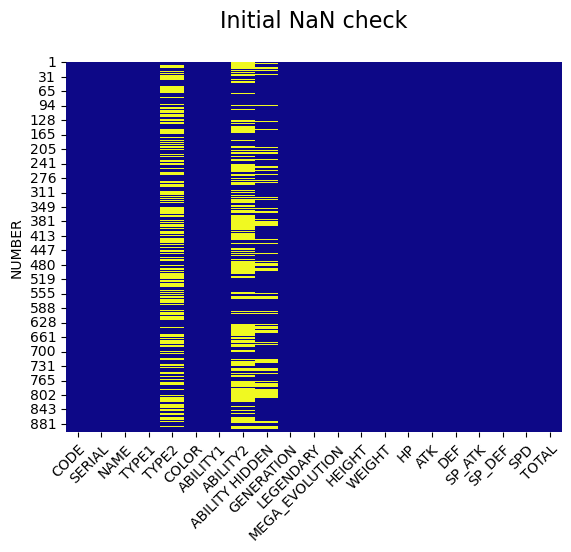

In [14]:
sns.heatmap(df.isnull(), cmap='plasma', cbar=False)
plt.title("Initial NaN check\n", 
          fontsize=16)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

#### Conclusion - columns with NaN values in yellow do not affect Pokemon strength calculations - remove them and proceed.

###  Find the Pokemon which is the most effective

In [15]:
def strength_rank(df:pd.DataFrame)->pd.DataFrame:
    """
    Get Pokemon rank from best to worst with given formula:
    1) Create a copy dataset and remove all columns containing NaN values.
    2) Add "Poke_strength" column indicating pokemon rank.
    3) Sort new dataset in descending order according to the rank.
    :param df: input dataset that must contain "ATK", "DEF", "SP_ATK" and "SP_DEF" columns.
    :return: dataframe with ranked Pokemon names.
    """
    df_strength = df.copy(deep=True) # deep copy to avoid unexpected behavior altering original dataset
    df_strength = df_strength.dropna(axis=1)  # remove all columns containing empty values
    df_strength["Poke_strength"] = (df["ATK"] - df["DEF"])*0.8 + (df["SP_ATK"] - df["SP_DEF"])*0.2
    return df_strength.sort_values(by="Poke_strength", ascending=False)

df_ranked = strength_rank(df)  # apply function
df_ranked.head(3) # display top 3 Pokemons

,CODE,SERIAL,NAME,TYPE1,COLOR,ABILITY1,GENERATION,LEGENDARY,MEGA_EVOLUTION,HEIGHT,WEIGHT,HP,ATK,DEF,SP_ATK,SP_DEF,SPD,TOTAL,Poke_strength
NUMBER,,,,,,,,,,,,,,,,,,,
896,1,8961,Glastrier,Ice,Chilling Neigh,8,2.2,800.0,100.0,145.0,130.0,65,110,30,580,3,30720,290,179.4
386,2,3862,Deoxys,Psychic,Red,Pressure,3.0,1.0,0.0,1.7,60.8,50,180,20,180,20,150,600,160.0
795,1,7951,Pheromosa,Bug,White,Beast Boost,7.0,1.0,0.0,1.8,25.0,71,137,37,137,37,151,570,100.0


### Export Ranked Pokemon data to Google Spreadsheets

In [16]:

credentials_path = './scandiweb-homework-67667ca89098.json'  # replace with your own path to credentials
spreadsheet_id = "1rjgKcRvLskt3KbL2KcGb27tvw9zVIy_9yU8GpvKzXrY" # replace with of your own Google Spreadsheets file with 
    # 'edit' access granted for Google Service Account client email address 
worksheet_n = "ranked_decs"


def save_to_gsheets(credentials_path:str=credentials_path,
                     spreadsheet_id:str=spreadsheet_id,
                     worksheet_name:str=worksheet_n,
                     data:pd.DataFrame=df_ranked)->None:
    """
    Save a DataFrame to a specified worksheet in a Google Spreadsheet.

    1) Connect to Google Sheets using a service account, opens the specified 
    spreadsheet and worksheet
    2) write the contents of the provided DataFrame to it. If the worksheet does not exist, it will be created. 
    Existing data in the worksheet will be cleared before writing new content.

    :param credentials_path: Path to the Google service account credentials JSON file.
    :param spreadsheet_id: The unique ID of the target Google Spreadsheet.
    :param worksheet_name: Name of the worksheet where the data will be saved.

    :return: None
    :raise:  Display an error message if the spreadsheet or worksheet is not found.
    :requirements:
        - `gspread`, `google-auth`, and `pandas` libraries must be installed.
        - Google service account must have edit access to the target spreadsheet.
    """

    scope = [
    "https://www.googleapis.com/auth/spreadsheets",  # grants permission for Google Sheets
    "https://www.googleapis.com/auth/drive.file",  # grants permission to Google Drive files
    ]

    sw_poke_cred = Credentials.from_service_account_file(credentials_path, scopes=scope)
    gc = gspread.authorize(sw_poke_cred)

    try:
        spreadsheet = gc.open_by_key(spreadsheet_id)
    except gspread.SpreadsheetNotFound:
        print(f"Spreadsheet # '{spreadsheet_id}' not found. Check the ID and try again.")

    try:
        worksheet = spreadsheet.worksheet(worksheet_name)
    except gspread.WorksheetNotFound:
        print(f"Worksheet '{worksheet_name}' not found. Creating new worksheet.")
        worksheet = spreadsheet.add_worksheet(title=worksheet_name, rows=data.shape[0] + 2, cols=data.shape[1] + 1)

    worksheet.clear()  # Clear existing data in the worksheet
    worksheet.update([df_ranked.columns.values.tolist()] + data.values.tolist())


save_to_gsheets()  # run export function